# Prepare Data for Training & Validating & Testing

Reference: https://github.com/PerpetualSmile/Sentiment-Analylsis-based-on-Attention-Mechanism/blob/master/Data%20Preprocess.ipynb

### **IMPORTANT**: 

*   Upload utils.py
*   Upload 'imdb_master.csv' 

*   Create the following folders in the same structure:
  *   dataset
      *   IMDB

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from utils import clean_text, clean_text_zh
%matplotlib inline
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Reading data

In [2]:
df = pd.read_csv('imdb_master.csv', encoding='latin-1', engine='python', error_bad_lines=False)

## Cleaning data

In [3]:
df = df[df['label'] != 'unsup']
df['label'] = df['label'].map({'neg':0, 'pos':1})

df['Processed_Reviews'] = df['review'].apply(clean_text)

## Splitting data

In [4]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0, stratify=df.label)
df_train, df_validate = train_test_split(df_train, test_size=5000, random_state=0, stratify=df_train.label)

## Save test.csv for attention visualization

In [7]:
df_test.to_csv (r'IMDB_test.csv', index = False, header=True)

## Size of train, validate and test dataset

In [8]:
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  40000
Validation set size:  5000
Test set size:  5000


## Plot distribution of sentence length

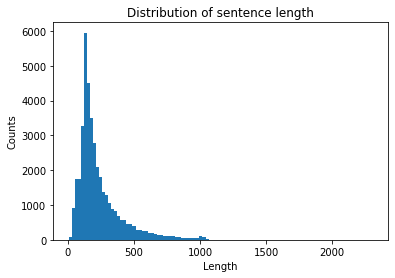

In [9]:
plt.figure()
_ = plt.hist(df_train.Processed_Reviews.apply(lambda x: len(x.split())), bins = 100)
plt.title('Distribution of sentence length')
plt.xlabel('Length')
plt.ylabel('Counts')
plt.savefig('Yelp_Distribution_of_sentence_length.png')

## Word sequence to num sequence

In [10]:
word_count = {}
def count(x):
    for word in x.split():
        word_count[word] = word_count.get(word, 0) + 1

In [11]:
_ = df_train.Processed_Reviews.apply(count)

In [12]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [13]:
df_word_count.drop(['the', 'a', 'and', 'of', 'to', 'br', 'in', 'this', 'that', 's'], inplace=True)

In [14]:
vocab_size = 20000
df_word_count = df_word_count[:vocab_size-3]

In [15]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 3 # reverse 0, 1, 2 for padding, BOS, EOS

In [16]:
X_train = df_train.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_train = df_train.label

## Process validation set and test set

In [17]:
X_val = df_validate.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
X_test = df_test.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_val = df_validate.label
y_test = df_test.label

## Save the data into hdf file format

In [18]:
X_train.to_hdf('dataset/IMDB/X_train.h5', key='s', mode='w')
y_train.to_hdf('dataset/IMDB/y_train.h5', key='s', mode='w')

X_val.to_hdf('dataset/IMDB/X_val.h5', key='s', mode='w')
y_val.to_hdf('dataset/IMDB/y_val.h5', key='s', mode='w')

X_test.to_hdf('dataset/IMDB/X_test.h5', key='s', mode='w')
y_test.to_hdf('dataset/IMDB/y_test.h5', key='s', mode='w')
word2num_series.to_hdf('dataset/IMDB/word2num_series.h5', key='s', mode='w')